# Next Pitch Prediction using LSTMs

## Data loading and sequencing

In [1]:
import os
import tensorflow as tf

os.chdir('..')
tf.keras.utils.set_random_seed(42)

In [3]:
from utils import preprocessing
from sklearn.model_selection import train_test_split

X, y_pitch, y_vertical, y_horizontal = preprocessing.get_sequences(os.path.join('data', 'raw', 'wade_miley_15-21.csv'))

# Split the data into training, validation, and testing sets
X_train, X_temp, y_pitch_train, y_pitch_temp, y_vertical_train, y_vertical_temp, y_horizontal_train, y_horizontal_temp = train_test_split(
    X, y_pitch, y_vertical, y_horizontal, test_size=0.4, random_state=42)

X_val, X_test, y_pitch_val, y_pitch_test, y_vertical_val, y_vertical_test, y_horizontal_val, y_horizontal_test = train_test_split(
    X_temp, y_pitch_temp, y_vertical_temp, y_horizontal_temp, test_size=0.5, random_state=42)

num_pitches = y_pitch.shape[1]
num_vertical_locs = y_vertical.shape[1]
num_horizontal_locs = y_horizontal.shape[1]

In [5]:
def build_network(input_layer, num_targets, name='', num_hidden_units=128, num_hidden_layers=1, activation='relu', reg=None, dropout=None):
    
    # Hidden layers
    x = input_layer
    for i in range(num_hidden_layers - 1):
        if reg:
            x = tf.keras.layers.LSTM(units=num_hidden_units, activation=activation, return_sequences=True, kernel_regularizer=reg)(x)
        else:
            x = tf.keras.layers.LSTM(units=num_hidden_units, activation=activation, return_sequences=True)(x)
        if dropout:
            x = tf.keras.layers.Dropout(dropout)(x)
    
    # Last hidden layer without return_sequences
    if reg:
        x = tf.keras.layers.LSTM(units=num_hidden_units, activation=activation, return_sequences=False, kernel_regularizer=reg)(x)
    else:
        x = tf.keras.layers.LSTM(units=num_hidden_units, activation=activation, return_sequences=False)(x)
    if dropout:
        x = tf.keras.layers.Dropout(dropout)(x)

    # Output layer
    outputs = tf.keras.layers.Dense(units=num_targets, activation='softmax', name=name)(x)

    return outputs

In [6]:
# Define the input layer
input_layer = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))

pitch_output = build_network(input_layer, num_targets=num_pitches, name='pitch_output')
vertical_output = build_network(input_layer, num_targets=num_vertical_locs, name='vertical_output')
horizontal_output = build_network(input_layer, num_targets=num_horizontal_locs, name='horizontal_output')

# Combine the models
ensemble_model = tf.keras.models.Model(inputs=input_layer, outputs=[pitch_output, vertical_output, horizontal_output])

# Compile the model
ensemble_model.compile(optimizer='adam',
                       loss={'pitch_output': 'categorical_crossentropy',
                             'vertical_output': 'categorical_crossentropy',
                             'horizontal_output': 'categorical_crossentropy'},
                       metrics=['accuracy', 'accuracy', 'accuracy'])

In [7]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_vertical_output_accuracy',
    patience=10,
    restore_best_weights=True,
    mode='max'
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_ensemble_model.keras',
    monitor='val_vertical_output_accuracy',
    save_best_only=True,
    mode='max'
)

# Train the model
history = ensemble_model.fit(X_train, 
                             {'pitch_output': y_pitch_train,
                              'vertical_output': y_vertical_train,
                              'horizontal_output': y_horizontal_train},
                             epochs=200, batch_size=64, 
                             validation_data=(X_val, 
                                              {'pitch_output': y_pitch_val,
                                               'vertical_output': y_vertical_val,
                                               'horizontal_output': y_horizontal_val}),
                             callbacks=[checkpoint_callback, early_stopping_callback],
                             verbose=0
                            )

ensemble_model = tf.keras.models.load_model('best_ensemble_model.keras')
test_loss, pitch_accuracy, vertical_accuracy, horizontal_accuracy = ensemble_model.evaluate(X_test, 
                                                                            {'pitch_output': y_pitch_test,
                                                                             'vertical_output': y_vertical_test,
                                                                             'horizontal_output': y_horizontal_test})
print(f"Pitch Test Accuracy: {pitch_accuracy}")
print(f"Vertical Test Accuracy: {vertical_accuracy}")
print(f"Horizontal Test Accuracy: {horizontal_accuracy}")

239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - horizontal_output_accuracy: 0.5525 - loss: 3.2800 - pitch_output_accuracy: 0.3945 - vertical_output_accuracy: 0.6607
Pitch Test Accuracy: 0.5476378202438354
Vertical Test Accuracy: 0.3992125988006592
Horizontal Test Accuracy: 0.6566929221153259


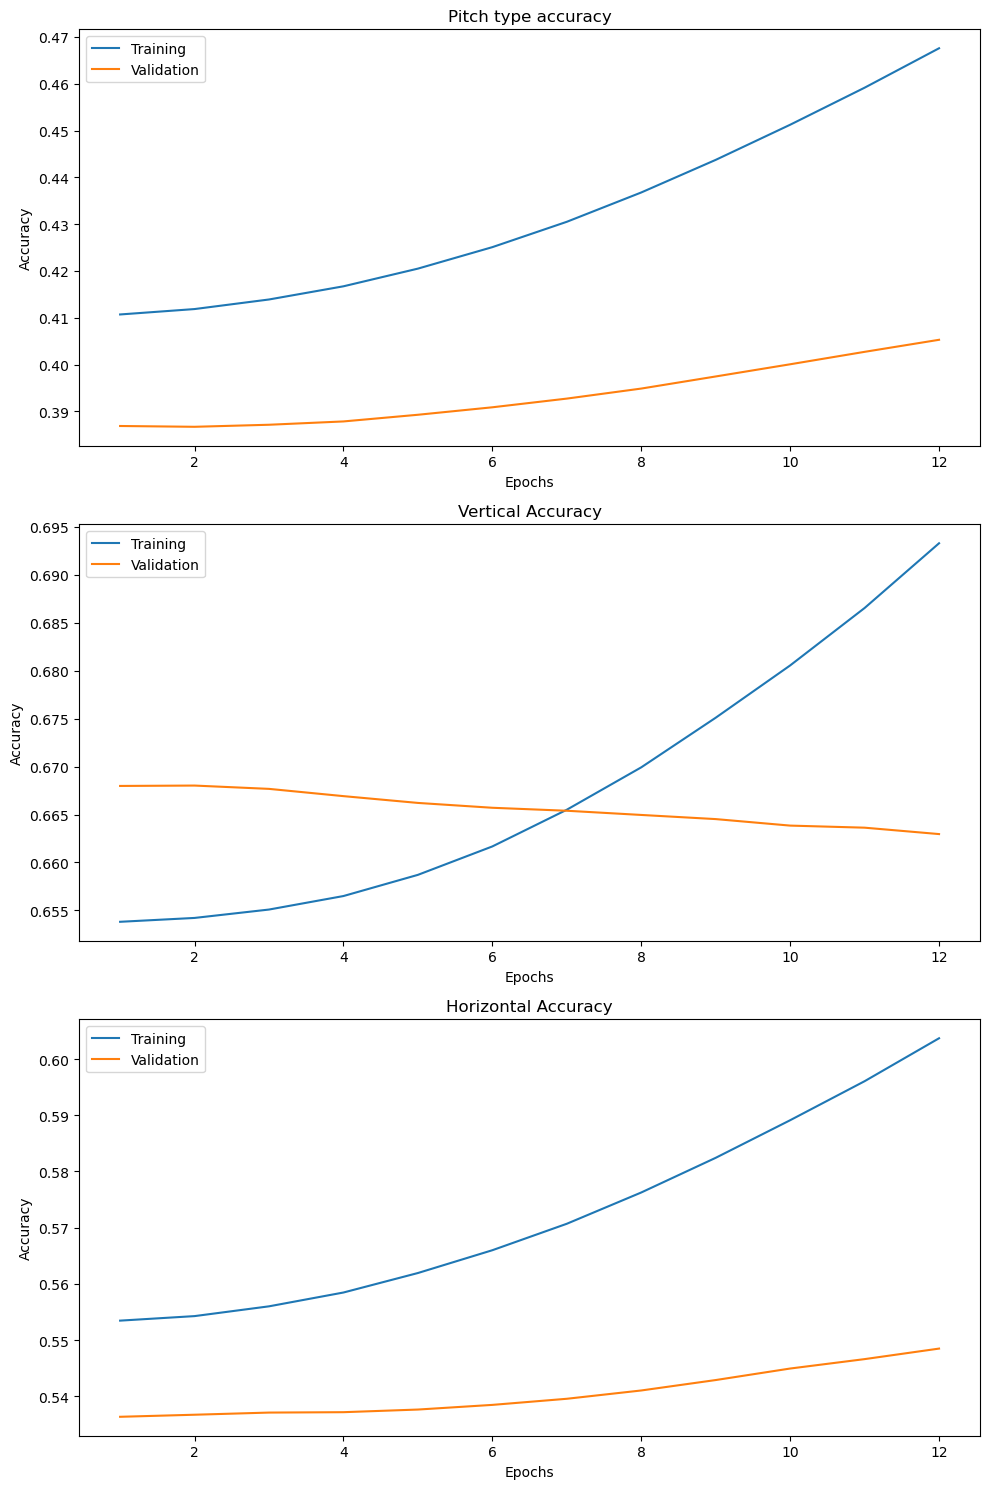

: 

In [ ]:
from utils.plot_utils import smooth_curve
import matplotlib.pyplot as plt

# Smooth the accuracy curves
smooth_pitch_accuracy = smooth_curve(history.history['pitch_output_accuracy'][5:])
smooth_val_pitch_accuracy = smooth_curve(history.history['val_pitch_output_accuracy'][5:])
smooth_vertical_accuracy = smooth_curve(history.history['vertical_output_accuracy'][5:])
smooth_val_vertical_accuracy = smooth_curve(history.history['val_vertical_output_accuracy'][5:])
smooth_horizontal_accuracy = smooth_curve(history.history['horizontal_output_accuracy'][5:])
smooth_val_horizontal_accuracy = smooth_curve(history.history['val_horizontal_output_accuracy'][5:])

# Create a grid of plots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot pitch accuracy
axs[0].plot(range(1, len(smooth_pitch_accuracy) + 1), smooth_pitch_accuracy, label='Training')
axs[0].plot(range(1, len(smooth_val_pitch_accuracy) + 1), smooth_val_pitch_accuracy, label='Validation')
axs[0].set_title('Pitch type accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot vertical accuracy
axs[1].plot(range(1, len(smooth_vertical_accuracy) + 1), smooth_vertical_accuracy, label='Training')
axs[1].plot(range(1, len(smooth_val_vertical_accuracy) + 1), smooth_val_vertical_accuracy, label='Validation')
axs[1].set_title('Vertical Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Plot horizontal accuracy
axs[2].plot(range(1, len(smooth_horizontal_accuracy) + 1), smooth_horizontal_accuracy, label='Training')
axs[2].plot(range(1, len(smooth_val_horizontal_accuracy) + 1), smooth_val_horizontal_accuracy, label='Validation')
axs[2].set_title('Horizontal Accuracy')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Accuracy')
axs[2].legend()

plt.tight_layout()
plt.show()